In [1]:
# ===============================
# Microgrid Load Forecasting & Demand Response Optimization
# Description: 
#   1) Load forecasting with LSTM
#   2) Define microgrid structure
#   3) Define demand response scenarios
#   4) Linear Programming optimization for demand response activation
#   5) Microgrid simulation and analysis
#   6) Save all results, plots, and reports to files
# ===============================

In [27]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import cvxpy as cp  # For Linear Programming

In [4]:
# ===============================
# Create necessary folders if not exist
# ===============================
os.makedirs("models", exist_ok=True)
os.makedirs("predictions", exist_ok=True)
os.makedirs("plots", exist_ok=True)
os.makedirs("reports", exist_ok=True)

In [5]:
# ===============================
# Step 1: Load and preprocess data
# ===============================
def load_and_preprocess_data(filename='AEP_hourly.csv'):
    df = pd.read_csv(filename)
    df['datetime'] = pd.to_datetime(df['datetime'])
    df = df.sort_values('datetime')

    # Remove outliers by IQR method
    Q1 = df['load'].quantile(0.25)
    Q3 = df['load'].quantile(0.75)
    IQR = Q3 - Q1
    df = df[(df['load'] >= Q1 - 1.5 * IQR) & (df['load'] <= Q3 + 1.5 * IQR)]

    # Feature engineering: time features
    df['hour'] = df['datetime'].dt.hour
    df['day_of_week'] = df['datetime'].dt.dayofweek

    # Normalize load
    scaler = MinMaxScaler()
    df['load_normalized'] = scaler.fit_transform(df['load'].values.reshape(-1, 1))

    # Rolling averages for trends
    df['rolling_6h'] = df['load_normalized'].rolling(window=6, min_periods=1).mean()
    df['rolling_12h'] = df['load_normalized'].rolling(window=12, min_periods=1).mean()
    df['rolling_24h'] = df['load_normalized'].rolling(window=24, min_periods=1).mean()

    # Fourier features for periodicity
    hours = (np.arange(len(df)) % 24) / 23
    days = (np.arange(len(df)) % 7) / 6
    df['fourier_hour_sin'] = np.sin(2 * np.pi * hours)
    df['fourier_hour_cos'] = np.cos(2 * np.pi * hours)
    df['fourier_day_sin'] = np.sin(2 * np.pi * days)
    df['fourier_day_cos'] = np.cos(2 * np.pi * days)

    return df, scaler

In [6]:
# ===============================
# Step 2: Create sequences for LSTM
# ===============================
def create_sequences(data, features, look_back=24, forecast_horizon=1):
    X, y = [], []
    data_values = data[features].values
    target_values = data['load_normalized'].values
    for i in range(len(data) - look_back - forecast_horizon + 1):
        X.append(data_values[i:i + look_back])
        y.append(target_values[i + look_back:i + look_back + forecast_horizon])
    return np.array(X), np.array(y).reshape(-1, forecast_horizon)

In [7]:
# ===============================
# Step 3: Build and train LSTM model
# ===============================
def build_and_train_model(X_train, y_train, X_val, y_val, look_back, n_features, forecast_horizon):
    model = Sequential([
        LSTM(32, input_shape=(look_back, n_features), return_sequences=True),
        Dropout(0.2),
        LSTM(16),
        Dropout(0.2),
        Dense(forecast_horizon)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(
        X_train, y_train,
        epochs=50,
        batch_size=32,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping],
        verbose=1
    )
    return model, history

In [8]:
# ===============================
# Step 4: Save trained model
# ===============================
def save_model(model, filename='models/lstm_load_forecast.h5'):
    model.save(filename)
    print(f"Model saved to {filename}")

In [9]:
# ===============================
# Step 5: Save predictions with datetime column
# ===============================
def save_predictions(datetime_index, y_true, y_pred, scaler, filename='predictions/predictions.csv'):
    y_true_actual = scaler.inverse_transform(y_true)
    y_pred_actual = scaler.inverse_transform(y_pred)

    df_pred = pd.DataFrame({
        'datetime': datetime_index.reset_index(drop=True),
        'Actual': y_true_actual.flatten(),
        'Predicted': y_pred_actual.flatten()
    })
    df_pred.to_csv(filename, index=False)
    print(f"Predictions saved to {filename}")
    return df_pred

In [10]:
# ===============================
# Step 6: Plot results and save figures
# ===============================
def plot_and_save_results(df_pred):
    plt.figure(figsize=(15, 6))
    plt.plot(df_pred['datetime'], df_pred['Actual'], label='Actual', color='blue')
    plt.plot(df_pred['datetime'], df_pred['Predicted'], label='Predicted', color='red', linestyle='--')
    plt.title('Actual vs Predicted Load')
    plt.xlabel('Datetime')
    plt.ylabel('Load (MW)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plot_path = 'plots/load_forecast.png'
    plt.savefig(plot_path)
    plt.show()
    print(f"Load forecast plot saved to {plot_path}")


def plot_error_distribution(df_pred):
    errors = df_pred['Actual'] - df_pred['Predicted']
    plt.figure(figsize=(12, 6))
    sns.histplot(errors, bins=50, kde=True)
    plt.title('Prediction Error Distribution')
    plt.xlabel('Error (Actual - Predicted)')
    plt.ylabel('Count')
    plt.tight_layout()
    plot_path = 'plots/error_distribution.png'
    plt.savefig(plot_path)
    plt.show()
    print(f"Error distribution plot saved to {plot_path}")

In [11]:
# ===============================
# Step 7: Evaluate model performance
# ===============================
def mean_absolute_percentage_error(y_true, y_pred):
    epsilon = 1e-10
    return np.mean(np.abs((y_true - y_pred) / (y_true + epsilon))) * 100


def evaluate_model(y_true, y_pred):
    metrics = {
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAPE': mean_absolute_percentage_error(y_true, y_pred),
        'R2': r2_score(y_true, y_pred)
    }
    print("\nModel Evaluation Results:")
    for k, v in metrics.items():
        print(f"{k}: {v:.4f}")
    return metrics


def save_report(metrics, train_samples, test_samples, filename='reports/load_forecasting_report.txt'):
    with open(filename, 'w') as f:
        f.write("LSTM Load Forecasting Model Report\n")
        f.write("========================================\n")
        f.write(f"Train Samples: {train_samples}\n")
        f.write(f"Test Samples: {test_samples}\n\n")
        for metric, value in metrics.items():
            f.write(f"{metric}: {value:.4f}\n")
    print(f"Report saved to {filename}")

In [12]:
# ===============================
# Step 8: Define microgrid daily load profile (simple example)
# ===============================
def define_microgrid():
    """
    Define a simple microgrid load profile over 24 hours.
    Load values are in kW.
    """
    hours = np.arange(24)
    # Example daily load profile (kW)
    load_profile = np.array([
        30, 28, 27, 25, 26, 30, 40, 55, 60, 65, 70, 68,
        66, 65, 63, 60, 55, 50, 45, 40, 38, 35, 32, 30
    ])
    df_load = pd.DataFrame({'hour': hours, 'load_kw': load_profile})
    df_load.to_csv('predictions/microgrid_load_profile.csv', index=False)
    print("Microgrid load profile saved to predictions/microgrid_load_profile.csv")
    return df_load

In [13]:
# ===============================
# Step 9: Define demand response scenarios
# ===============================
def define_demand_response_scenarios():
    """
    Define DR reduction percentage for each hour of day.
    For example, in peak hours DR can reduce load by 20%.
    """
    dr_reduction = np.array([
        0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.10, 0.15, 0.20, 0.20, 0.20, 0.15,
        0.15, 0.15, 0.10, 0.10, 0.10, 0.05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0
    ])
    return dr_reduction

In [28]:
# ===============================
# Step 10: Linear Programming Optimization for DR
# ===============================
def run_lp_optimization(load_profile, dr_reduction):
    """
    Linear Programming to minimize total load after DR.
    Decision variables: x_i ∈ [0,1], indicating DR activation fraction for hour i
    Objective: minimize sum of load_i * (1 - dr_reduction_i * x_i)
    Constraints:
      - 0 <= x_i <= 1
      - total DR activation limited to max_total_dr (hours)
    """
    n_hours = len(load_profile)
    x = cp.Variable(n_hours)  # decision variables: fraction of DR activation per hour

    # Objective function
    adjusted_load = cp.multiply(load_profile, (1 - dr_reduction * x))
    objective = cp.Minimize(cp.sum(adjusted_load))

    # Constraints
    constraints = [x >= 0, x <= 1]

    # Limit total DR activation (e.g., max 4 hours full activation)
    max_total_dr = 4
    constraints.append(cp.sum(x) <= max_total_dr)

    problem = cp.Problem(objective, constraints)
    problem.solve(solver=cp.SCS)

    if problem.status not in ["infeasible", "unbounded"]:
        print(f"Optimal total adjusted load: {problem.value:.2f}")
        dr_activation = x.value
    else:
        print(f"Problem status: {problem.status}")
        dr_activation = np.zeros(n_hours)

    return dr_activation

In [15]:
# ===============================
# Step 11: Simulate microgrid with DR applied
# ===============================
def simulate_microgrid_with_dr(load_profile, dr_reduction, dr_activation):
    """
    Calculate load after DR activation.
    """
    adjusted_load = load_profile * (1 - dr_reduction * dr_activation)
    df = pd.DataFrame({
        'hour': np.arange(len(load_profile)),
        'original_load_kw': load_profile,
        'dr_activation_fraction': dr_activation,
        'dr_reduction': dr_reduction,
        'adjusted_load_kw': adjusted_load
    })
    df.to_csv('predictions/microgrid_load_with_dr.csv', index=False)
    print("Microgrid load with DR saved to predictions/microgrid_load_with_dr.csv")
    return df

In [16]:
# ===============================
# Step 12: Plot and save DR results
# ===============================
def plot_dr_results(df_dr):
    plt.figure(figsize=(12, 6))
    plt.plot(df_dr['hour'], df_dr['original_load_kw'], label='Original Load', marker='o')
    plt.plot(df_dr['hour'], df_dr['adjusted_load_kw'], label='Load after DR', marker='x')
    plt.xlabel('Hour of Day')
    plt.ylabel('Load (kW)')
    plt.title('Microgrid Load Before and After Demand Response')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plot_path = 'plots/microgrid_load_dr.png'
    plt.savefig(plot_path)
    plt.show()
    print(f"Demand Response results plot saved to {plot_path}")

In [17]:
# ===============================
# Step 13: Generate final report
# ===============================
def generate_final_report(metrics_forecast, dr_df, filename='reports/final_project_report.txt'):
    with open(filename, 'w') as f:
        f.write("Microgrid Load Forecasting and Demand Response Optimization Report\n")
        f.write("===============================================================\n\n")

        f.write("Load Forecasting Metrics:\n")
        for metric, value in metrics_forecast.items():
            f.write(f"{metric}: {value:.4f}\n")
        f.write("\n")

        f.write("Demand Response Summary:\n")
        total_original_load = dr_df['original_load_kw'].sum()
        total_adjusted_load = dr_df['adjusted_load_kw'].sum()
        total_reduction = total_original_load - total_adjusted_load

        f.write(f"Total Original Load (24h): {total_original_load:.2f} kW\n")
        f.write(f"Total Load after DR (24h): {total_adjusted_load:.2f} kW\n")
        f.write(f"Total Load Reduction: {total_reduction:.2f} kW\n\n")

        f.write("DR Activation (hour by hour):\n")
        for hour, activation in zip(dr_df['hour'], dr_df['dr_activation_fraction']):
            f.write(f"Hour {hour}: {activation:.3f}\n")

    print(f"Final report saved to {filename}")

In [18]:
# ===============================
# Main execution script
# ===============================
def main():
    # === Load and preprocess data ===
    df, scaler = load_and_preprocess_data('AEP_hourly.csv')

    # === Prepare sequences ===
    features = ['load_normalized', 'hour', 'day_of_week', 'rolling_6h', 'rolling_12h', 'rolling_24h',
                'fourier_hour_sin', 'fourier_hour_cos', 'fourier_day_sin', 'fourier_day_cos']
    look_back = 24
    forecast_horizon = 1

    X, y = create_sequences(df, features, look_back, forecast_horizon)

    # === Train-test split ===
    train_size = int(len(X) * 0.8)
    X_train, y_train = X[:train_size], y[:train_size]
    X_val, y_val = X[train_size:], y[train_size:]

    # === Build and train LSTM ===
    model, history = build_and_train_model(X_train, y_train, X_val, y_val,
                                           look_back, len(features), forecast_horizon)
    save_model(model)

    # === Predict ===
    y_pred = model.predict(X_val)
    datetime_pred = df['datetime'].iloc[train_size + look_back:train_size + look_back + len(y_val)]

    # === Save predictions ===
    df_pred = save_predictions(datetime_pred, y_val, y_pred, scaler)

    # === Plot results ===
    plot_and_save_results(df_pred)
    plot_error_distribution(df_pred)

    # === Evaluate model ===
    y_true_actual = scaler.inverse_transform(y_val)
    y_pred_actual = scaler.inverse_transform(y_pred)
    metrics = evaluate_model(y_true_actual, y_pred_actual)
    save_report(metrics, train_samples=len(X_train), test_samples=len(X_val))

    # === Define microgrid ===
    microgrid_load_df = define_microgrid()
    load_profile = microgrid_load_df['load_kw'].values

    # === Define DR scenarios ===
    dr_reduction = define_demand_response_scenarios()

    # === Run Linear Programming optimization for DR ===
    dr_activation = run_lp_optimization(load_profile, dr_reduction)

    # === Simulate microgrid with DR applied ===
    dr_df = simulate_microgrid_with_dr(load_profile, dr_reduction, dr_activation)

    # === Plot DR results ===
    plot_dr_results(dr_df)

    # === Generate final comprehensive report ===
    generate_final_report(metrics, dr_df)

Epoch 1/50


C:\Users\pariz\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3015/3015 ━━━━━━━━━━━━━━━━━━━━ 33s 10ms/step - loss: 0.0168 - mae: 0.0931 - val_loss: 0.0014 - val_mae: 0.0312
Epoch 2/50
3015/3015 ━━━━━━━━━━━━━━━━━━━━ 29s 10ms/step - loss: 0.0023 - mae: 0.0368 - val_loss: 9.8042e-04 - val_mae: 0.0260
Epoch 3/50
3015/3015 ━━━━━━━━━━━━━━━━━━━━ 27s 9ms/step - loss: 0.0016 - mae: 0.0302 - val_loss: 5.0597e-04 - val_mae: 0.0182
Epoch 4/50
3015/3015 ━━━━━━━━━━━━━━━━━━━━ 29s 10ms/step - loss: 0.0013 - mae: 0.0276 - val_loss: 3.0546e-04 - val_mae: 0.0133
Epoch 5/50
3015/3015 ━━━━━━━━━━━━━━━━━━━━ 32s 11ms/step - loss: 0.0013 - mae: 0.0266 - val_loss: 4.6769e-04 - val_mae: 0.0167
Epoch 6/50
3015/3015 ━━━━━━━━━━━━━━━━━━━━ 30s 10ms/step - loss: 0.0012 - mae: 0.0256 - val_loss: 3.9261e-04 - val_mae: 0.0155
Epoch 7/50
3015/3015 ━━━━━━━━━━━━━━━━━━━━ 30s 10ms/step - loss: 0.0011 - mae: 0.0250 - val_loss: 2.8065e-04 - val_mae: 0.0130
Epoch 8/50
3015/3015 ━━━━━━━━━━━━━━━━━━━━ 32s 10ms/step - loss: 0.0011 - mae: 0.0245 - val_loss: 2.4284e-04 - val_mae: 0.0119
Epoch 9/

Model saved to models/lstm_load_forecast.h5
754/754 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
Predictions saved to predictions/predictions.csv


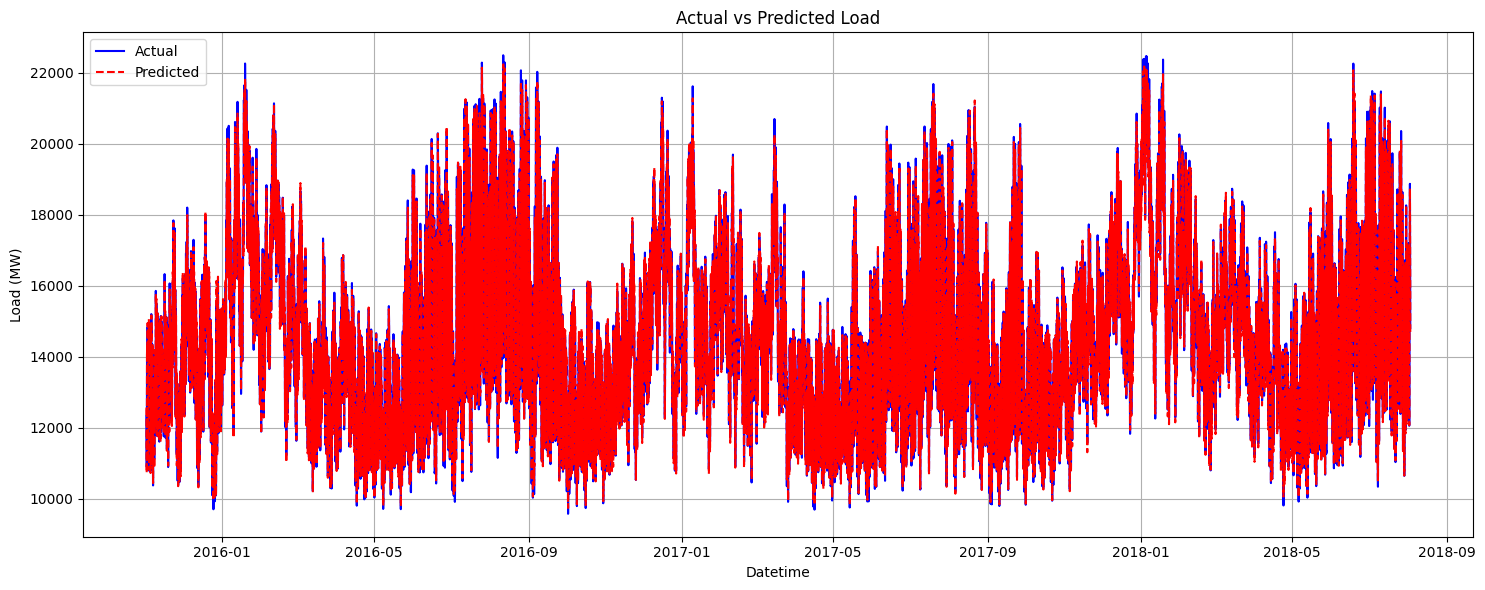

Load forecast plot saved to plots/load_forecast.png


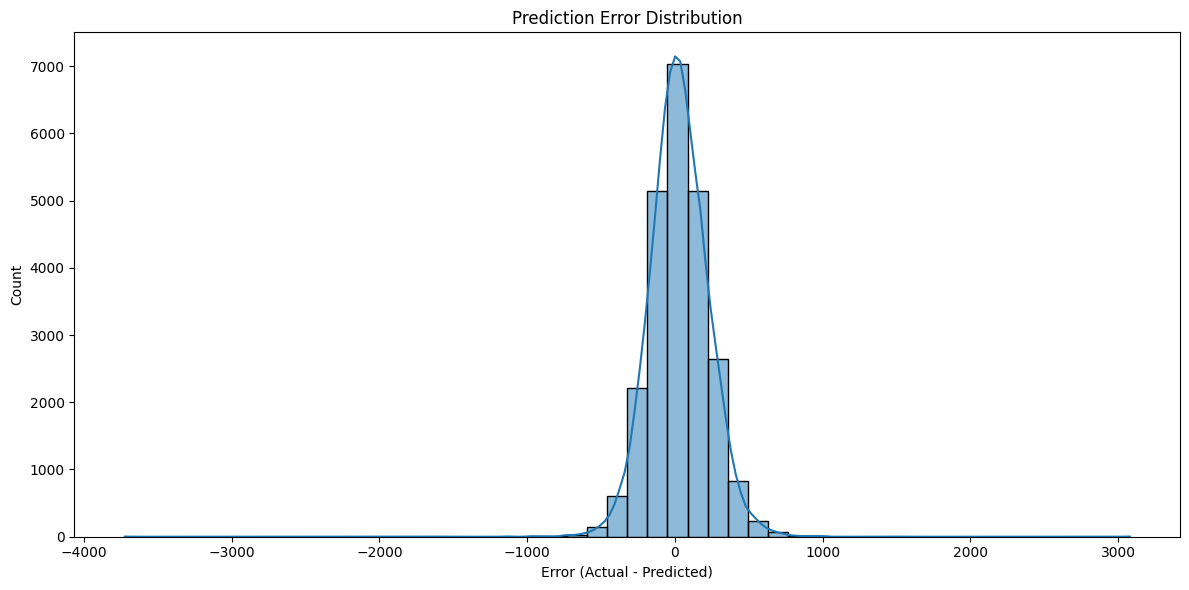

Error distribution plot saved to plots/error_distribution.png

Model Evaluation Results:
MAE: 154.8697
RMSE: 202.1628
MAPE: 1.0601
R2: 0.9932
Report saved to reports/load_forecasting_report.txt
Microgrid load profile saved to predictions/microgrid_load_profile.csv
Optimal total adjusted load: 275.75
Microgrid load with DR saved to predictions/microgrid_load_with_dr.csv


C:\Users\pariz\AppData\Local\Programs\Python\Python312\Lib\site-packages\cvxpy\expressions\expression.py:674: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 5 times so far.

  warnings.warn(msg, UserWarning)


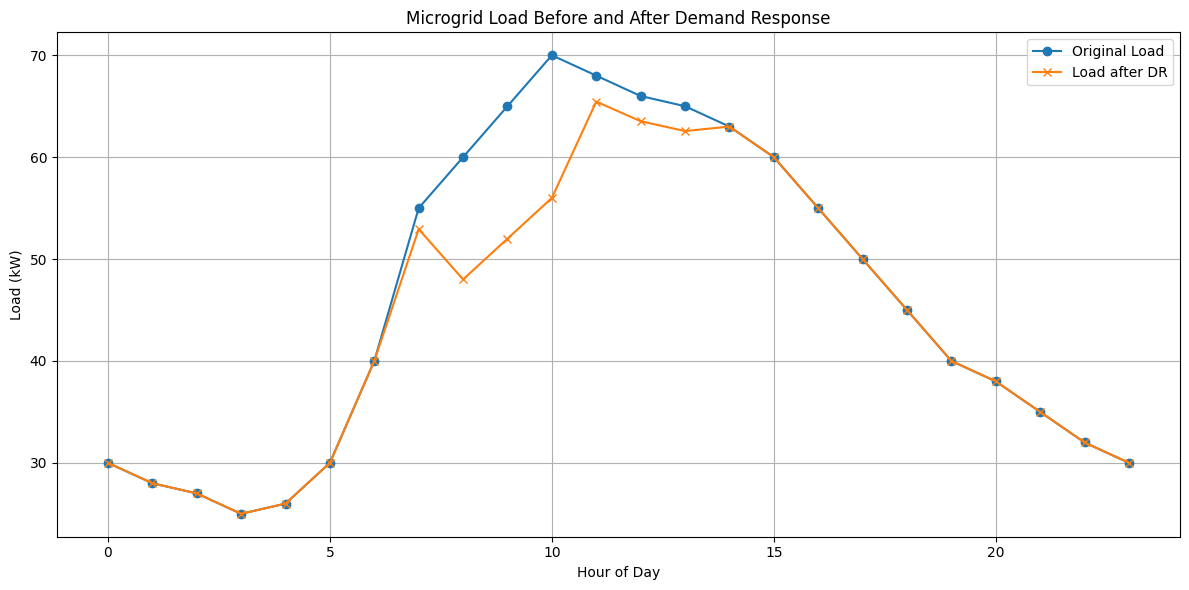

Demand Response results plot saved to plots/microgrid_load_dr.png
Final report saved to reports/final_project_report.txt


In [33]:
if __name__ == "__main__":
    main()